In [1]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from neuropix import io, viz, pipeline, analyze, utils
from neuropix.signal import processing, detection
import teamutils
import matplotlib.pyplot as plt

In [2]:
path_bin = teamutils.get_bin_path(Chosen_Animal = 'SA8', Chosen_Insertion = 3)
path_meta = teamutils.get_metadata_path(path_bin)

meta_dict, meta_raw = io.parse_metadata(path_meta)
arrays_spikes_dict = io.get_spike_arrays(os.path.dirname(path_meta))

In [3]:
window = 10
start_times = [meta_dict["duration"]-window]
channels = [0]
conv_to_uv=True
get_all_channels = True
time_unit = 's'

data_array, time_array, _ = io.get_data(path_bin, meta_dict, start_times = start_times,
            window = window, channels = channels, convert_to_uv=conv_to_uv,
            get_all_channels=get_all_channels, time_unit=time_unit)

In [4]:
func_1 = processing.notch_filter(freq = 50.0, fs = meta_dict["sampling_rate"], q=30.0, axis = 1)
func_2 = processing.lowpass_filter(lowcut=250.0, fs = meta_dict["sampling_rate"], axis = 1)
# func_3 = processing.resample_torch(fs = meta_dict["sampling_rate"], new_fs = 500, axis = 1)
func_3 = processing.resample_scipy(fs = meta_dict["sampling_rate"], new_fs = 500, axis = 1)
func_4 = detection.artefacts_by_max_in_window(window_size = 500, overlap = 250, threshold = 350)
func_5 = processing.interp_nan_in_channel_by_weighted_average()

data_prep, new_time_array, new_fs = pipeline.apply_preprocess(data_array[0], time_array[0], meta_dict["sampling_rate"], [func_1, func_2, func_3], batch_mode=True, batch_size=int(meta_dict["sampling_rate"]), overlap=1000)

In [5]:
data_segment, time_segment = utils.extract_time_segment(data_prep[0],new_time_array, 13630, 13632)

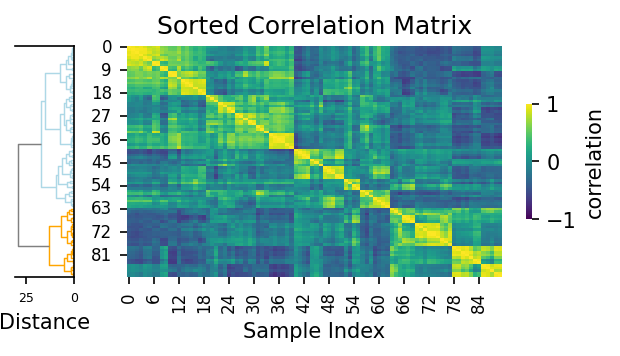

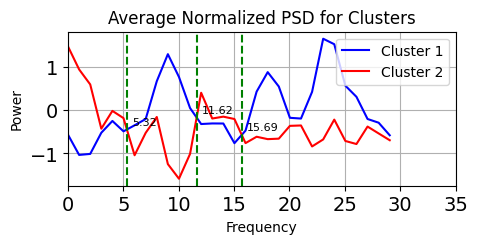

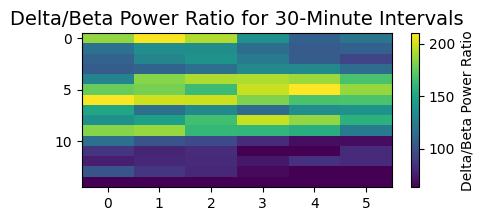

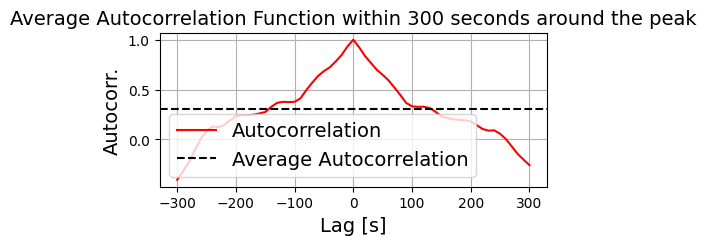

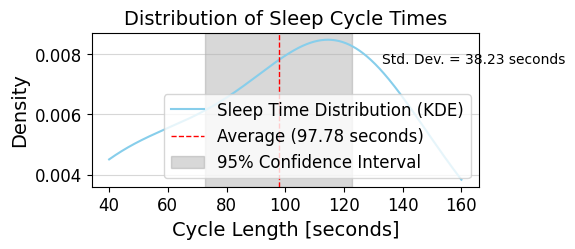

In [6]:
sleep_res_dict = pipeline.apply_sleep_analysis(data_prep, new_fs)

In [7]:
data_bins = analyze.get_bins_array(data=data_prep, fs=new_fs)
freq, PSD = analyze.compute_power_spectrum(data_bins, fs=new_fs,nperseg=new_fs)
nPSD_low = analyze.normalize_power_spectrum(PSD[:,:30])
correlation_matrix = analyze.corr_matrix(nPSD_low)
linkage_matrix, cluster_labels, clusters, avg_psd_cluster = analyze.cluster_correlation_matrix(correlation_matrix, nPSD_low, num_clusters=20)
transition_frequencies = analyze.calculate_transition_frequency(freq[:30], avg_psd_cluster[0], avg_psd_cluster[1])
delta_beta_ratio = analyze.calculate_delta_beta_ratio(PSD)
norm_autocorr = analyze.cross_corr(delta_beta_ratio, delta_beta_ratio)
dict_sleep_cycles = analyze.analyze_sleep_cycles(norm_autocorr)

In [ ]:
fig, _, _ = viz.plot_sorted_correlation_matrix(correlation_matrix, linkage_matrix)
fig = viz.plot_transition_frequency(freq[:30], avg_psd_cluster[0], avg_psd_cluster[1], transition_frequencies)
fig = viz.plot_delta_beta_matrix(delta_beta_ratio, num_bins_x = 6)
fig = viz.plot_autocorr(norm_autocorr, np.argmax(norm_autocorr), peak_range = 300, bin_second = 10)
fig = viz.plot_kde_distribution(dict_sleep_cycles)